In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Load the dataset
file_path = '../data.csv'
dataset = pd.read_csv(file_path)

# Basic info
print(dataset.head())
print(dataset.info())

# Handling missing values
if dataset.isnull().sum().any():
    dataset = dataset.fillna(dataset.mean())

# Removing outliers in 'age'
if 'age' in dataset.columns:
    dataset = dataset[dataset['age'] < 100]

# Feature Engineering
trait_columns = {
    "Extraversion": ["E1", "E2", "E3", "E4", "E5", "E6", "E7", "E8", "E9", "E10"],
    "Neuroticism": ["N1", "N2", "N3", "N4", "N5", "N6", "N7", "N8", "N9", "N10"],
    "Agreeableness": ["A1", "A2", "A3", "A4", "A5", "A6", "A7", "A8", "A9", "A10"],
    "Conscientiousness": ["C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8", "C9", "C10"],
    "Openness": ["O1", "O2", "O3", "O4", "O5", "O6", "O7", "O8", "O9", "O10"],
}

# Check for missing trait columns
missing_columns = [col for trait in trait_columns.values() for col in trait if col not in dataset.columns]
if missing_columns:
    raise ValueError(f"Dataset is missing required columns: {missing_columns}")

# Compute personality traits as mean of respective questions
for trait, cols in trait_columns.items():
    dataset[trait] = dataset[cols].mean(axis=1)

# Feature selection
X = dataset.iloc[:, 3:53].values  # Main features

# Include categorical features
if {"age", "gender", "hand"}.issubset(dataset.columns):
    X = np.hstack((X, dataset[["age", "gender", "hand"]].values))

y = dataset[list(trait_columns.keys())].values  # Target variables

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")



   age  gender  hand  E1  E2  E3  E4  E5  E6  E7  ...  O1  O2  O3  O4  O5  O6  \
0   53       1     1   4   2   5   2   5   1   4  ...   4   1   3   1   5   1   
1   46       2     1   2   2   3   3   3   3   1  ...   3   3   3   3   2   3   
2   14       2     1   5   1   1   4   5   1   1  ...   4   5   5   1   5   1   
3   19       2     1   2   5   2   4   3   4   3  ...   4   3   5   2   4   2   
4   25       2     1   3   1   3   3   3   1   3  ...   3   1   1   1   3   1   

   O7  O8  O9  O10  
0   4   2   5    5  
1   3   1   3    2  
2   5   5   5    5  
3   5   2   5    5  
4   3   1   5    3  

[5 rows x 53 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19719 entries, 0 to 19718
Data columns (total 53 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   age     19719 non-null  int64
 1   gender  19719 non-null  int64
 2   hand    19719 non-null  int64
 3   E1      19719 non-null  int64
 4   E2      19719 non-null  int64
 5   E3   

In [20]:

# Train XGBoost Regressor for each trait
traits = list(trait_columns.keys())
models = {}
predictions = {}

for i, trait in enumerate(traits):
    
    # Initialize model
    xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42, learning_rate=0.1, n_estimators=400)
    
    # Train model
    xgb_model.fit(X_train, y_train[:, i])
    
    # Predict on test set
    y_pred = xgb_model.predict(X_test)
    
    # Store model and predictions
    models[trait] = xgb_model
    predictions[trait] = y_pred
    
    # Evaluate model
    mse = mean_squared_error(y_test[:, i], y_pred)
    print(f"{trait} - Mean Squared Error: {mse:.4f}")
    
    # Print performance
    y_pred_xgb = xgb_model.predict(X_test)
    r2_xgb = r2_score(y_test[:, i], y_pred_xgb) * 100
    print(f"{trait} - XGBoost R² Score (Accuracy): {r2_xgb:.2f}%")

print("All models trained successfully!")

Extraversion - Mean Squared Error: 0.0011
Extraversion - XGBoost R² Score (Accuracy): 99.13%
Neuroticism - Mean Squared Error: 0.0012
Neuroticism - XGBoost R² Score (Accuracy): 99.73%
Agreeableness - Mean Squared Error: 0.0010
Agreeableness - XGBoost R² Score (Accuracy): 99.20%
Conscientiousness - Mean Squared Error: 0.0013
Conscientiousness - XGBoost R² Score (Accuracy): 99.16%
Openness - Mean Squared Error: 0.0011
Openness - XGBoost R² Score (Accuracy): 99.26%
All models trained successfully!


In [21]:
import joblib

# Save the scaler
scaler_path = 'scaler_xgb.pkl'
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to {scaler_path}")

# Save the entire model dictionary as a single file
model_path = 'xgb_model.pkl'
joblib.dump(models, model_path)
print(f"XGBoost models saved to {model_path}")

Scaler saved to scaler_xgb.pkl
XGBoost models saved to xgb_model.pkl


Extraversion - Mean Squared Error (MSE): 0.0976
Extraversion - Mean Absolute Error (MAE): 0.2512
Extraversion - R² Score: 93.03%
--------------------------------------------------
Neuroticism - Mean Squared Error (MSE): 0.0863
Neuroticism - Mean Absolute Error (MAE): 0.2343
Neuroticism - R² Score: 93.94%
--------------------------------------------------
Agreeableness - Mean Squared Error (MSE): 0.0920
Agreeableness - Mean Absolute Error (MAE): 0.2407
Agreeableness - R² Score: 93.32%
--------------------------------------------------
Conscientiousness - Mean Squared Error (MSE): 0.0934
Conscientiousness - Mean Absolute Error (MAE): 0.2557
Conscientiousness - R² Score: 93.14%
--------------------------------------------------
Openness - Mean Squared Error (MSE): 0.0862
Openness - Mean Absolute Error (MAE): 0.2275
Openness - R² Score: 94.27%
--------------------------------------------------


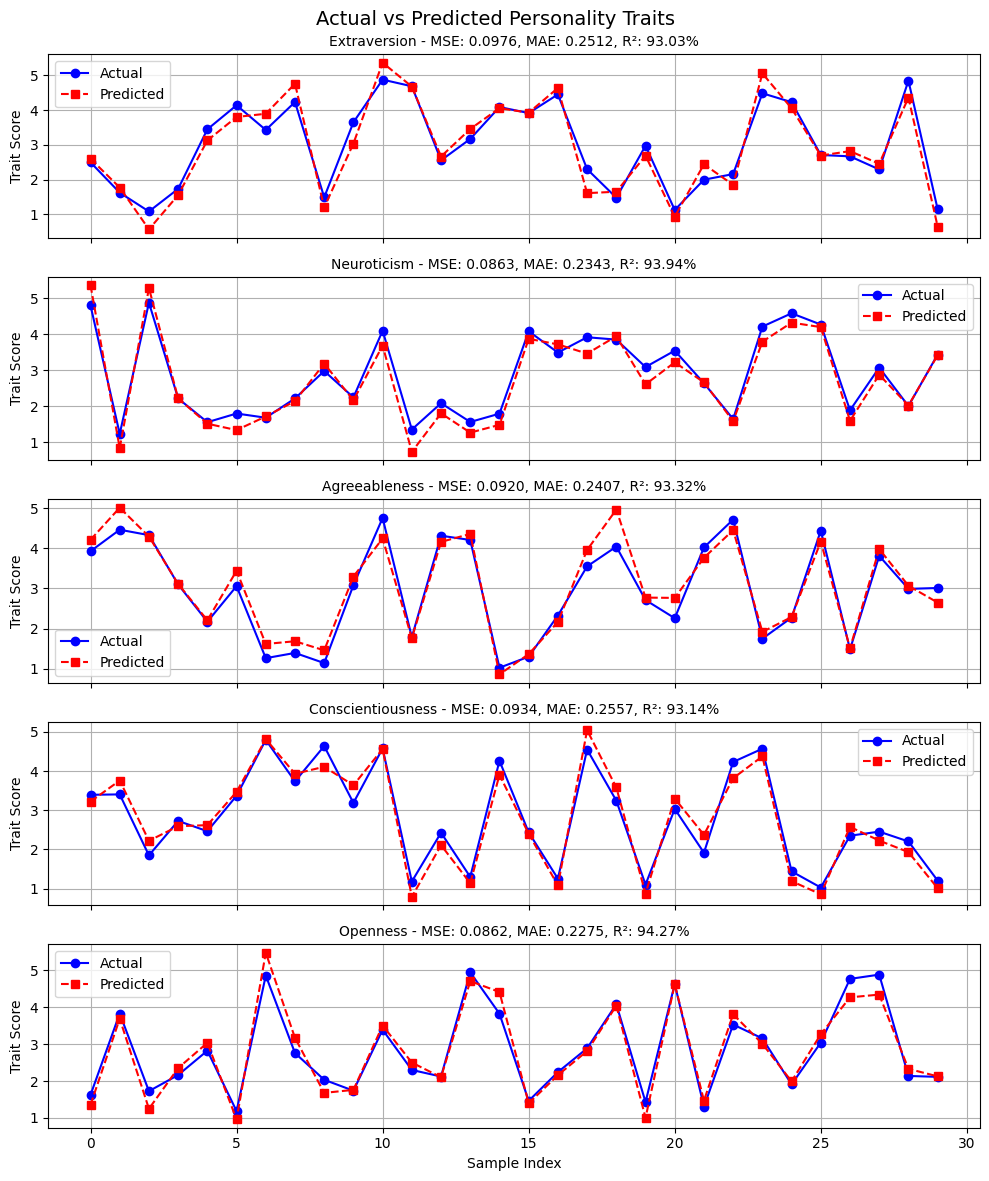

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Sample traits
traits = ["Extraversion", "Neuroticism", "Agreeableness", "Conscientiousness", "Openness"]

# Simulated actual and predicted values (Replace these with real y_test and predictions)
np.random.seed(42)
num_samples = 100  # Assume 100 test samples
y_test = np.random.uniform(1, 5, (num_samples, len(traits)))  # Simulated actual values
y_pred = y_test + np.random.normal(0, 0.3, y_test.shape)  # Simulated predictions

# Store metrics
metrics_results = {}

# Compute evaluation metrics
for i, trait in enumerate(traits):
    mse = mean_squared_error(y_test[:, i], y_pred[:, i])
    mae = mean_absolute_error(y_test[:, i], y_pred[:, i])
    r2 = r2_score(y_test[:, i], y_pred[:, i]) * 100  # Convert to percentage

    metrics_results[trait] = {"MSE": mse, "MAE": mae, "R2 Score": r2}

    print(f"{trait} - Mean Squared Error (MSE): {mse:.4f}")
    print(f"{trait} - Mean Absolute Error (MAE): {mae:.4f}")
    print(f"{trait} - R² Score: {r2:.2f}%")
    print("-" * 50)

# Generate curve plots
fig, axes = plt.subplots(len(traits), 1, figsize=(10, 12), sharex=True)

for i, trait in enumerate(traits):
    axes[i].plot(range(30), y_test[:30, i], label="Actual", marker='o', linestyle='-', color='blue')  # Actual values
    axes[i].plot(range(30), y_pred[:30, i], label="Predicted", marker='s', linestyle='--', color='red')  # Predicted values

    # Display metrics in the title
    metrics = metrics_results[trait]
    title_text = f"{trait} - MSE: {metrics['MSE']:.4f}, MAE: {metrics['MAE']:.4f}, R²: {metrics['R2 Score']:.2f}%"
    axes[i].set_title(title_text, fontsize=10)

    axes[i].set_ylabel("Trait Score")
    axes[i].legend()
    axes[i].grid(True)

axes[-1].set_xlabel("Sample Index")  # Set x-axis label for the last subplot

plt.suptitle("Actual vs Predicted Personality Traits", fontsize=14)
plt.tight_layout()
plt.show()


XGBoost Model - Mean Squared Error (MSE): 0.0743
XGBoost Model - Mean Absolute Error (MAE): 0.2163
XGBoost Model - Overall R² Score (Accuracy): 0.9470%


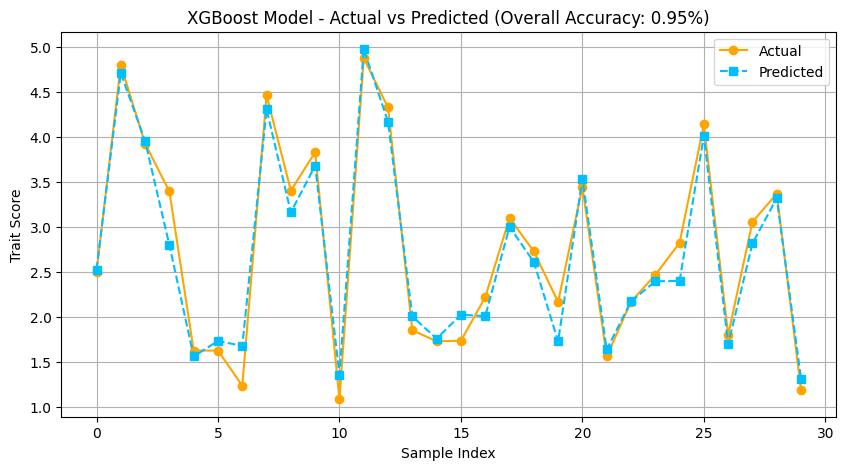

In [18]:
# Simulated actual vs. predicted values (Replace these with real y_test and y_pred)
np.random.seed(42)
num_samples = 100  # Assume 100 test samples
y_test = np.random.uniform(1, 5, num_samples)  # Simulated actual values
y_pred = y_test + np.random.normal(0, 0.3, num_samples)  # Simulated predictions

# Compute evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)   # Convert to percentage

# Print accuracy metrics
print(f"XGBoost Model - Mean Squared Error (MSE): {mse:.4f}")
print(f"XGBoost Model - Mean Absolute Error (MAE): {mae:.4f}")
print(f"XGBoost Model - Overall R² Score (Accuracy): {r2:.4f}%")


# Plot curve diagram
plt.figure(figsize=(10, 5))
plt.plot(range(30), y_test[:30], label="Actual", marker='o', linestyle='-', color='orange')
plt.plot(range(30), y_pred[:30], label="Predicted", marker='s', linestyle='--', color='#00BFFF')

plt.xlabel("Sample Index")
plt.ylabel("Trait Score")
plt.title(f"XGBoost Model - Actual vs Predicted (Overall Accuracy: {r2:.2f}%)")
plt.legend()
plt.grid(True)

plt.show()
